# Objetivo

Este notebook tem como objetivo extrair dados sobre bandas de metal do estado de São Paulo até o ano de 2024, a partir do site [metal-archives.com](https://www.metal-archives.com/search/advanced/searching/bands?bandName=&genre=&country=BR&yearCreationFrom=&yearCreationTo=2024&bandNotes=&status=&themes=&location=S%C3%A3o+Paulo&bandLabelName=#bands) e responder as seguintes perguntas:

1. Quais são os subgêneros mais frequentes?
2. Quais anos tiveram mais bandas formadas?
3. Qual é a ditribuição da duração das bandas que acabaram?
4. Quais são os temas mais frequentes nas letras das bandas?
5. Qual é a distribuição do tempo até primeiro lançamento?
6. Qual é a proporção de bandas que lançaram um álbum completo?
7. Quais são as gravadoras mais frequentes?
8. Qual é a proporção de bandas sem gravadora?
9. Das bandas que tiveram hiatos, qual é distribuição da quantidade de hiatos banda?
10. Qual é banda mais antiga?
11. Qual é a banda mais antiga que ainda está em atividade?

# Schema

A coleta dos dados e análise se baseará em apenas um csv chamado "bandas_sp.csv" com as seguintes colunas:

- **url**: URL da página de detalhes da banda, servira como identificador único.
- **nome**: Nome da banda.
- **generos**: Lista dos gêneros da banda, exatamente como vem no site (mais tarde precisaremos tratar esse dado para extrair cada gênero).
- **ano_formacao**: Ano de formação da banda. Pode vir como N/A caso esse dado não tenha sido fornecido.
- **anos_atividade**: Anos de atividade da banda. Aqui que aparecem os hiatos.
- **temas**: Lista de temas que aparecem nas letras da banda, exatamente como vem no site (mais tarde precisaremos tratar esse dado para extrair cada gênero).
- **ano_primeiro_lancamento**: Ano do primeiro lançamento, independente do tipo de lançamento (álbum, demo, single, etc.). Caso não tenha lançamento, vem como 'sem_lancamento'.
- **lancou_album_completo**: 1 para sim e 0 para não, se lançou ou não um álbum completo.
- **gravadora_mais_recente**: Última gravadora da banda. Caso não tenha, vem como "sem_gravadora".

# Extraindo os dados

Vamos utilizar Selenium no python para realizar o web scrapping. A biblioteca undetected_chromedriver serve para driblar o captcha. Importando bliotecas necessárias:

In [202]:
import pandas as pd
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import undetected_chromedriver as uc
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

## Constantes

Aqui serão declaradas as constantes, como a URL inicial e os seletores CSS dos elementos que serão clicados e raspados:

In [ ]:
URL_INICIAL='https://www.metal-archives.com/search/advanced/searching/bands?bandName=&genre=&country=BR&yearCreationFrom=&yearCreationTo=2024&bandNotes=&status=&themes=&location=S%C3%A3o+Paulo&bandLabelName=#bands'
NOME_PLANILHA='dados.csv'
SELETOR_LISTA_BANDAS_BOTAO_PROXIMA_PAGINA='.paging_full_numbers:not(#searchResultsBand_paginate) .next.paginate_button:not(.paginate_button_disabled)'
SELETOR_LISTA_BANDAS_LINHA='#searchResultsBand tr.odd, #searchResultsBand tr.even'
SELETOR_LISTA_BANDAS_LINHA_NOME='a'
SELETOR_LISTA_BANDAS_LINHA_GENEROS='td:nth-child(2)'
SELETOR_LISTA_BANDAS_LINHA_ANO_INICIO='td:nth-child(4)'
SELETOR_BANDA_ANOS_ATIVIDADE='#band_stats .clear dd'
SELETOR_BANDA_gravadoras='#band_stats .float_right dd:nth-of-type(2)'
SELETOR_BANDA_ANO_PRIMEIRO_LANCAMENTO='.discog tbody tr:first-of-type td:nth-of-type(3)'
SELETOR_BANDA_DISCOG='.discog tbody'
SELETOR_BANDA_GRAVADORA_MAIS_RECENTE='#band_stats .float_right dd:nth-of-type(3)'
SELENIUM_WAIT=10
VALOR_NAO_INFORMADO='nao_informado'


## Configurando o data frame

Rode essa linha para inicializar ou reinicar o dataframe

In [ ]:
df = pd.DataFrame(columns=['url', 'nome', 'generos', 'ano_formacao', 'anos_atividade', 'temas', 'ano_primeiro_lancamento', 'lancou_album_completo', 'gravadora_mais_recente'])

# Inicializa driver

In [3]:
driver = uc.Chrome()

## Inicializa funções utilizadas ao longo do código

In [189]:
def obter_texto_do_elemento(elemento):
    return elemento.text or elemento.get_attribute('textContent')

def contem_palavra_no_html(html, palavra):
    html_lower = html.lower()
    palavra_lower = palavra.lower()
    return palavra_lower in html_lower

def cor_preta(*args, **kwargs):
    return "black"

def limpar_linha(linha):
    #O campo ano_formacao veio no formato 1998.0, com esse zero a mais. Vamos remover:
    ano_formacao = linha['ano_formacao']
    if (ano_formacao == 'nan'):
        linha['ano_formacao'] = VALOR_NAO_INFORMADO 
    elif pd.isna(ano_formacao):
        linha['ano_formacao'] = VALOR_NAO_INFORMADO
    else:
        linha['ano_formacao'] = str(int(ano_formacao))
    #Remove 'metal' dos gêneros para focar nos subgêneros e padroniza separação de gêneros com |
    generos = re.sub(r'[/ ,;]+', '|', (linha['generos'] or '').lower().replace('metal', '').replace('(early)', '').replace('(later)', '').strip())
    linha['generos'] = generos
    #Padroniza separação por | no campo temas
    temas = linha['temas']
    if (pd.isna(temas)):
        temas = VALOR_NAO_INFORMADO
    else:
        temas = re.sub(r'[/ ,;]+', '|', str(linha['temas']).lower().replace('metal', '').replace('(early)', '').replace('(later)', '').strip())
    linha['temas'] = temas
    #Remove vazios em anos_atividade
    anos_atividade = linha['anos_atividade']
    if (pd.isna(anos_atividade)):
        anos_atividade = VALOR_NAO_INFORMADO
    linha['anos_atividade'] = anos_atividade

    return linha

def plot_big_number(number, text):# Cria uma figura grande e limpa
    plt.figure(figsize=(6,4))
    plt.axis('off')  # Remove os eixos para destacar só o número

    # Exibe o big number centralizado, com estilo grande e negrito
    plt.text(0.5, 0.5, f"{number*100:.1f}%", 
            fontsize=72, fontweight='bold', color='#2a9d8f',
            ha='center', va='center', fontfamily='DejaVu Sans')

    # Opcional: adicionar um subtítulo explicativo abaixo
    plt.text(0.5, 0.3, text,
            fontsize=18, ha='center', va='center', color='#264653')

    plt.tight_layout()
    plt.show()
    
def banda_terminou(anos_atividade):
    if pd.isna(anos_atividade):
        return False
    anos_atividade = anos_atividade.lower()
    # Considera que a banda terminou se não contém 'present' e contém '-'
    return ('present' not in anos_atividade) and ('-' in anos_atividade)


# Função para calcular o tempo de atividade (em anos)
def calcular_tempo_atividade(anos_atividade):
    if pd.isna(anos_atividade):
        return np.nan
    anos_atividade = anos_atividade.lower()
    # Ignora bandas ainda ativas ou formato inválido
    if 'present' in anos_atividade or '-' not in anos_atividade:
        return np.nan
    try:
        inicio, fim = anos_atividade.split('-')
        inicio = int(inicio.strip())
        fim = int(fim.strip())
        return fim - inicio
    except:
        return np.nan


## Percorrendo a lista de bandas

Primeiro vamos extrair os dados disponíveis na lista de bandas do estado de São Paulo:

In [4]:
driver.get(URL_INICIAL)

Espere a janela abrir e verifique se é necessário confirmar que é humano antes de seguir com a coleta

In [ ]:
while True:
    current_html = driver.page_source
    linhas = driver.find_elements(By.CSS_SELECTOR, SELETOR_LISTA_BANDAS_LINHA)
    for linha in linhas:
        link_nome = linha.find_element(By.CSS_SELECTOR, SELETOR_LISTA_BANDAS_LINHA_NOME)
        try:
            url = link_nome.get_attribute('href')
            elemento_genero = linha.find_element(By.CSS_SELECTOR, SELETOR_LISTA_BANDAS_LINHA_GENEROS)
            elemento_ano_formacao = linha.find_element(By.CSS_SELECTOR, SELETOR_LISTA_BANDAS_LINHA_ANO_INICIO)
        except:
            print(linha.get_attribute('outerHTML'))
        
        new_line = pd.DataFrame([{
            'url': url,
            'nome': link_nome.text,
            'generos': elemento_genero.text,
            'ano_formacao': elemento_ano_formacao.text,
        }])
        
        df = pd.concat([df, new_line], ignore_index=True)
    
    try:    
        driver.find_element(By.CSS_SELECTOR, SELETOR_LISTA_BANDAS_BOTAO_PROXIMA_PAGINA).click()
        time.sleep(1)
    except:
        df.to_csv(NOME_PLANILHA, index=False)
        break
    

## Preenchendo dados faltantes de cada banda

Agora vamos entrar na página de detalhes de cada banda que ainda não tem todas as colunas preenchidas para obter os dados faltantes

In [55]:
buffer = 1
current = 0

df = pd.read_csv(NOME_PLANILHA, index_col=False, keep_default_na=False)

for index, row in df.iterrows():
    if(row.drop(['nome', 'generos', 'ano_formacao']) == "").any():
        current = current + 1
        
        driver.get(row['url'])
        
        try:
            df.at[index, 'anos_atividade'] = obter_texto_do_elemento(driver.find_element(By.CSS_SELECTOR, SELETOR_BANDA_ANOS_ATIVIDADE))
            df.at[index, 'temas'] = obter_texto_do_elemento(driver.find_element(By.CSS_SELECTOR, SELETOR_BANDA_TEMAS)) or 'sem_tema'
            discog_element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, SELETOR_BANDA_DISCOG)))
            discog_html = discog_element.get_attribute('outerHTML')
            df.at[index, 'lancou_album_completo'] = contem_palavra_no_html(discog_html, 'Full-length')
            discog_vazia = contem_palavra_no_html(discog_html, 'Nothing entered yet')
            if (discog_vazia): df.at[index, 'ano_primeiro_lancamento'] = 'sem_lancamento'
            else: df.at[index, 'ano_primeiro_lancamento'] = obter_texto_do_elemento(driver.find_element(By.CSS_SELECTOR, SELETOR_BANDA_ANO_PRIMEIRO_LANCAMENTO))
            df.at[index, 'gravadora_mais_recente'] = obter_texto_do_elemento(driver.find_element(By.CSS_SELECTOR, SELETOR_BANDA_GRAVADORA_MAIS_RECENTE))
        except:
            print('ERRO nessa banda:', url)
            raise    
        if (current == buffer):
            df.to_csv(NOME_PLANILHA, index=False)
            current = 0

df.to_csv(NOME_PLANILHA, index=False)

## Limpando os dados

Vvamos criar uma cópia do csv gerado e vamos limpar a cópia.

In [172]:
#campos: 'url', 'nome', 'generos', 'ano_formacao', 'anos_atividade', 'temas', 'ano_primeiro_lancamento', 'lancou_album_completo', 'gravadora_mais_recente'

df = pd.read_csv('dados.csv')

df_limpo = df.apply(limpar_linha, axis=1)

df_limpo.to_csv('dados_limpos.csv', index=False)


## Respondendo perguntas

In [173]:
df = pd.read_csv('dados_limpos.csv')


### Quais são os subgêneros mais frequentes?

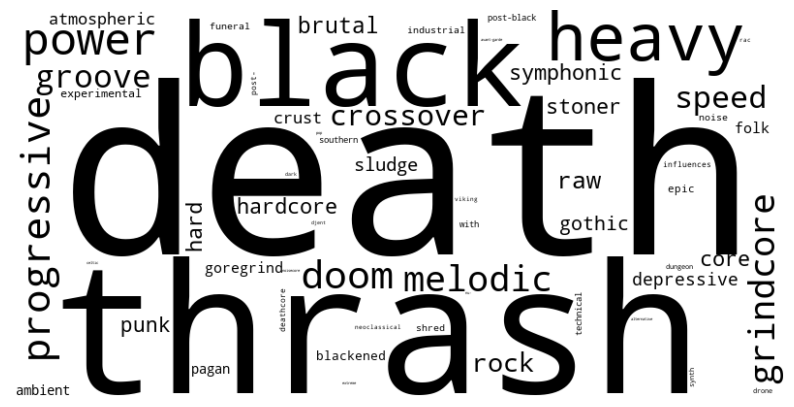

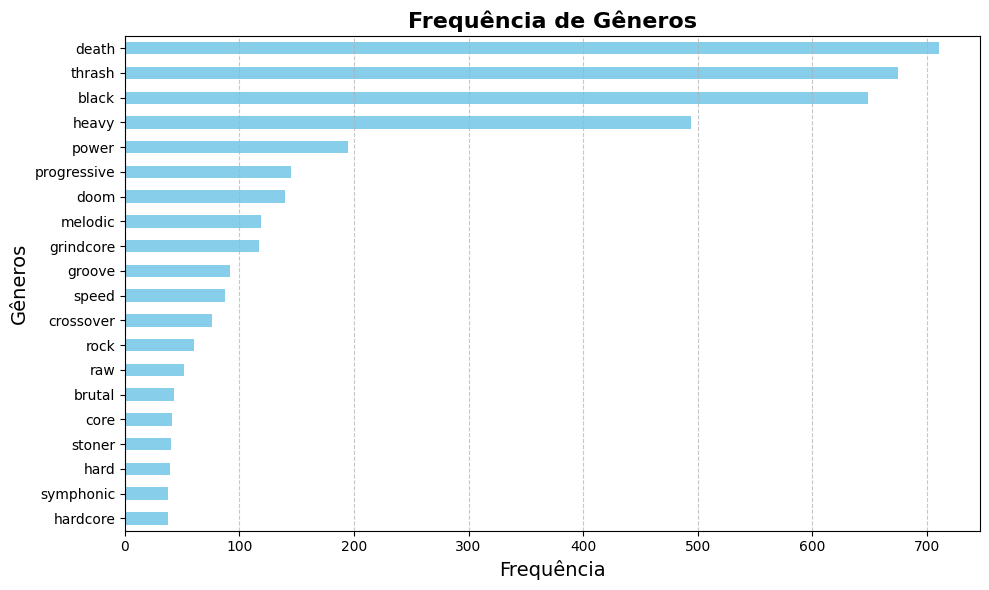

In [174]:

lista_generos = df['generos'].str.split('|')
lista_generos_explodida = lista_generos.explode()

#word cloud
frequencia_generos = lista_generos_explodida.value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencia_generos)
wordcloud = wordcloud.recolor(color_func=cor_preta)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



plt.figure(figsize=(10, 6))
ax = frequencia_generos.sort_values(ascending=False).head(20).plot(kind='barh', color='skyblue')  # ordena para barras do menor para o maior (visualização mais natural)
ax.invert_yaxis()
plt.title('Frequência de Gêneros', fontsize=16, fontweight='bold')
plt.xlabel('Frequência', fontsize=14)
plt.ylabel('Gêneros', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

frequencia_generos.to_csv('ranking_generos.csv')



### Quais anos tiveram mais bandas formadas?

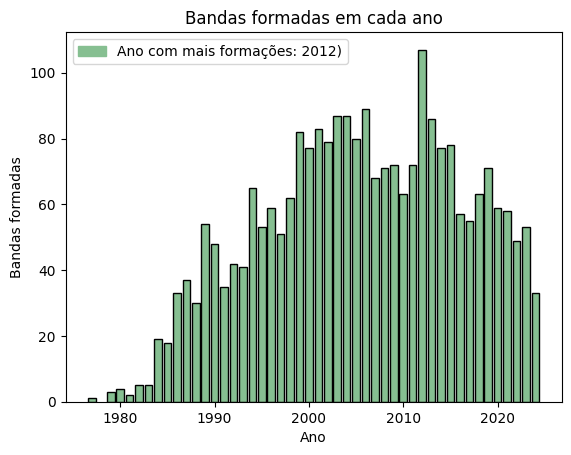

In [145]:
# Supondo que df['ano_formacao'] já está numérico
data = df['ano_formacao'].dropna()

# Conta a frequência de cada ano
freq_ano = data.value_counts().sort_index()

# Pega os anos e as frequências correspondentes
anos = freq_ano.index.astype(int)
frequencias = freq_ano.values

# Cria o gráfico de barras
plt.bar(anos, frequencias, color='#86bf91', edgecolor='black')

# Encontra o ano com maior frequência
max_idx = np.argmax(frequencias)
max_ano = anos[max_idx]
max_freq = frequencias[max_idx]

# Adiciona título e labels
plt.title('Bandas formadas em cada ano')
plt.xlabel('Ano')
plt.ylabel('Bandas formadas')

# Cria legenda com o ano de maior frequência
import matplotlib.patches as mpatches
patch = mpatches.Patch(color='#86bf91', label=f'Ano com mais formações: {max_ano})')
plt.legend(handles=[patch], loc='upper left')

plt.show()

### Qual é a ditribuição da duração das bandas que acabaram?

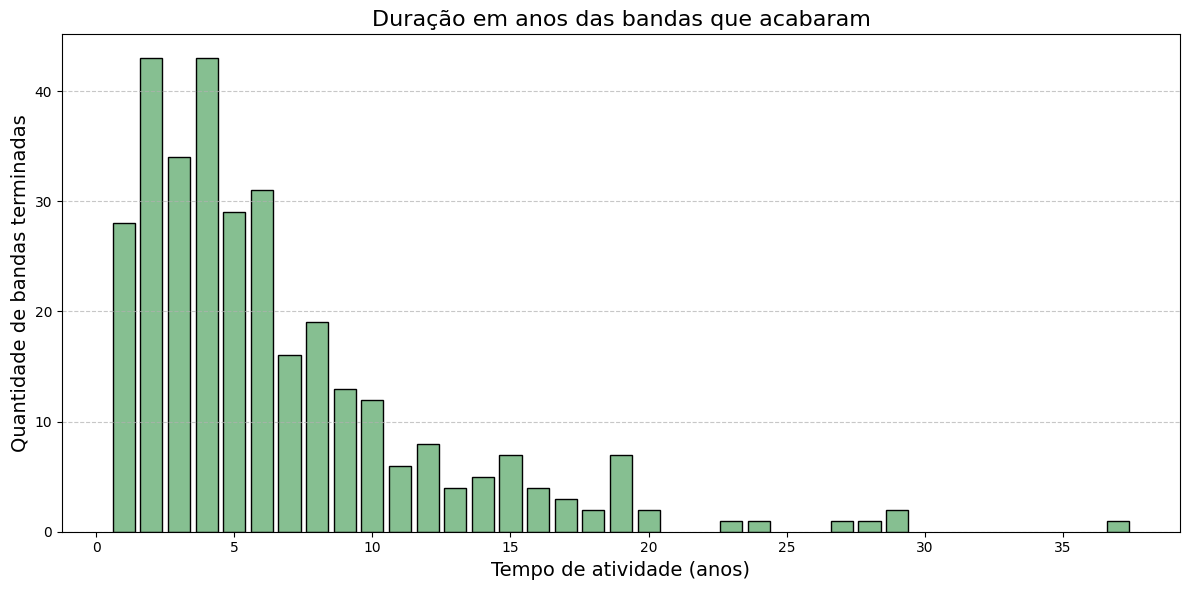

In [ ]:
# Filtra o DataFrame para bandas terminadas
df_terminadas = df[df['anos_atividade'].apply(banda_terminou)].copy()

# Aplica o cálculo do tempo de atividade
df_terminadas['tempo_atividade'] = df_terminadas['anos_atividade'].apply(calcular_tempo_atividade)

# Remove linhas com tempo de atividade inválido
df_tempo = df_terminadas.dropna(subset=['tempo_atividade'])

# Conta a frequência de bandas terminadas por tempo de atividade
freq_tempo = df_tempo['tempo_atividade'].value_counts().sort_index()

anos = freq_tempo.index.astype(int)
frequencias = freq_tempo.values

# Cria o gráfico de barras
plt.figure(figsize=(12,6))
plt.bar(anos, frequencias, color='#86bf91', edgecolor='black')

# Identifica o tempo de atividade com maior quantidade de bandas terminadas
max_idx = np.argmax(frequencias)
max_ano = anos[max_idx]
max_freq = frequencias[max_idx]

# Configurações do gráfico
plt.title('Duração em anos das bandas que acabaram', fontsize=16)
plt.xlabel('Tempo de atividade (anos)', fontsize=14)
plt.ylabel('Quantidade de bandas terminadas', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Quais são os temas mais frequentes nas letras das bandas?

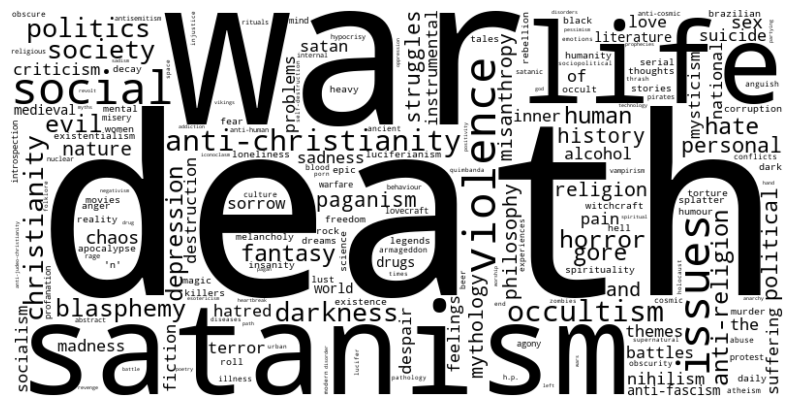

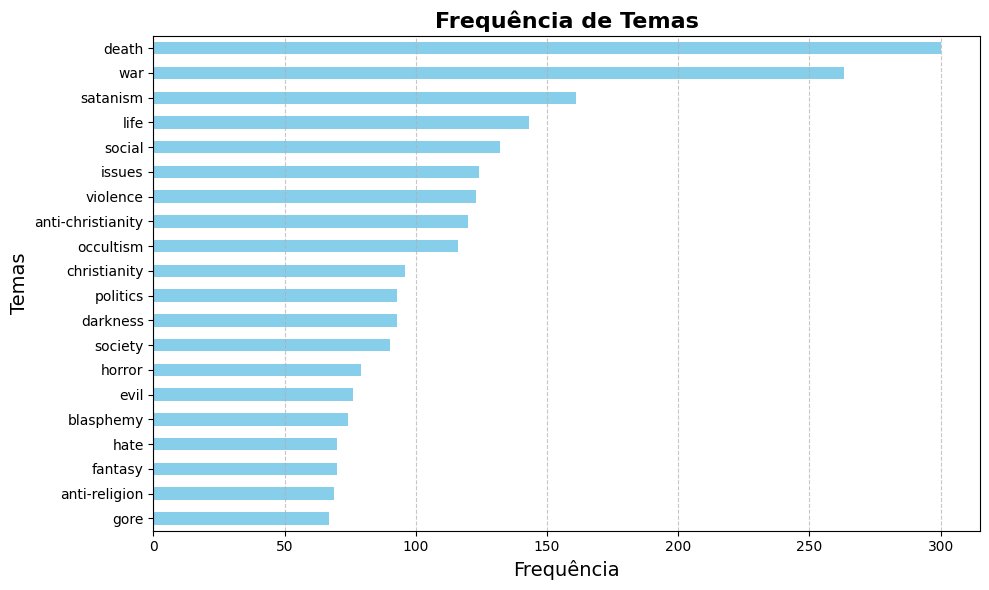

In [ ]:
lista_temas = df['temas'].str.split('|')
lista_temas_explodida = lista_temas.explode()
lista_temas_filtrada = lista_temas_explodida.loc[lista_temas_explodida != 'nao_informado']

#word cloud
frequencia_temas = lista_temas_filtrada.value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencia_temas)
wordcloud = wordcloud.recolor(color_func=cor_preta)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 6))
ax = frequencia_temas.sort_values(ascending=False).head(20).plot(kind='barh', color='skyblue')  # ordena para barras do menor para o maior (visualização mais natural)
ax.invert_yaxis()
plt.title('Frequência de Temas', fontsize=16, fontweight='bold')
plt.xlabel('Frequência', fontsize=14)
plt.ylabel('Temas', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

frequencia_temas.to_csv('ranking_temas.csv')

### Qual é a distribuição do tempo até primeiro lançamento?

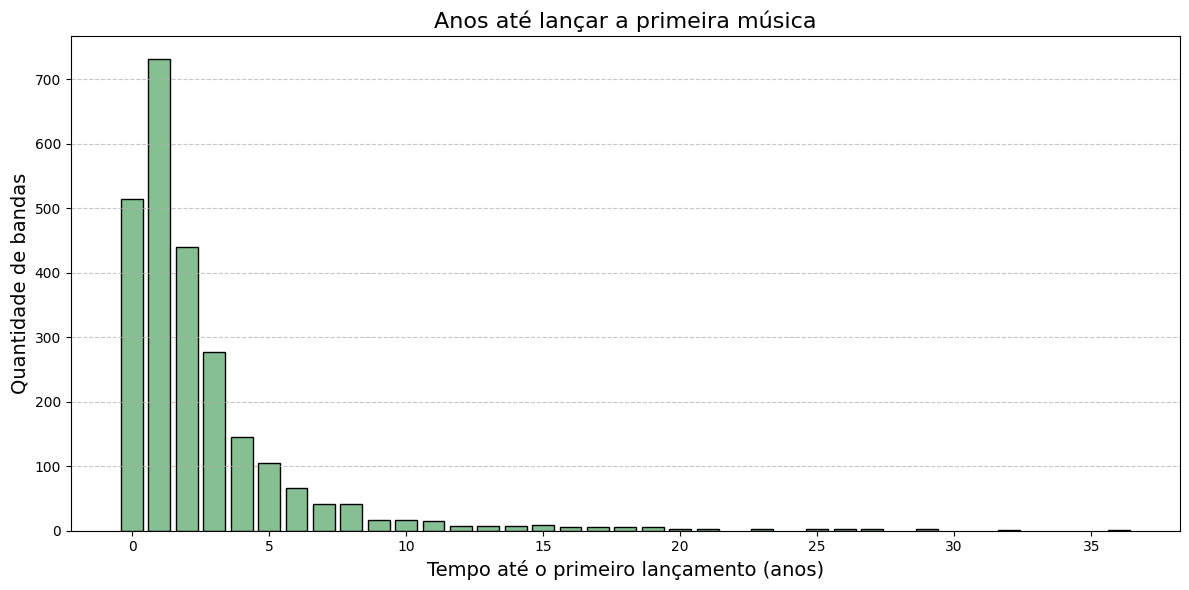

In [179]:
df_com_lancamento = df.dropna(subset=['ano_formacao', 'ano_primeiro_lancamento']).copy()

# Remove linhas onde ano_formacao ou ano_primeiro_lancamento não são numéricos ou são inválidos
def eh_numero(val):
    try:
        int(val)
        return True
    except:
        return False

df_com_lancamento = df_com_lancamento[
    df_com_lancamento['ano_formacao'].apply(eh_numero) &
    df_com_lancamento['ano_primeiro_lancamento'].apply(eh_numero)
].copy()

# Converte para inteiro
df_com_lancamento['ano_formacao'] = df_com_lancamento['ano_formacao'].astype(int)
df_com_lancamento['ano_primeiro_lancamento'] = df_com_lancamento['ano_primeiro_lancamento'].astype(int)

# Calcula o tempo até o primeiro lançamento
df_com_lancamento['tempo_ate_primeiro_lancamento'] = (
    df_com_lancamento['ano_primeiro_lancamento'] - df_com_lancamento['ano_formacao']
)

# Remove tempos negativos ou inválidos (caso o primeiro lançamento seja anterior à formação)
df_com_lancamento = df_com_lancamento[df_com_lancamento['tempo_ate_primeiro_lancamento'] >= 0]

# Conta a frequência de bandas por tempo até o primeiro lançamento
freq_tempo_lancamento = df_com_lancamento['tempo_ate_primeiro_lancamento'].value_counts().sort_index()

anos = freq_tempo_lancamento.index.astype(int)
frequencias = freq_tempo_lancamento.values

# Cria o gráfico de barras
plt.figure(figsize=(12,6))
plt.bar(anos, frequencias, color='#86bf91', edgecolor='black')

# Identifica o tempo com maior quantidade de bandas
max_idx = np.argmax(frequencias)
max_ano = anos[max_idx]
max_freq = frequencias[max_idx]

plt.title('Anos até lançar a primeira música', fontsize=16)
plt.xlabel('Tempo até o primeiro lançamento (anos)', fontsize=14)
plt.ylabel('Quantidade de bandas', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Qual é a proporção de bandas que lançaram um álbum completo?

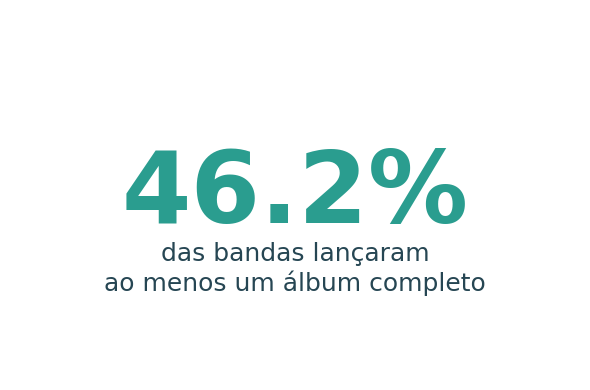

In [187]:
num_lancaram_album = df['lancou_album_completo'].sum()

# Conta o total de bandas com informação válida nessa coluna
total_bandas = df['lancou_album_completo'].count()

# Calcula a proporção
proporcao = num_lancaram_album / total_bandas

plot_big_number(proporcao, "das bandas lançaram\nao menos um álbum completo")


### Quais são as gravadoras mais frequentes?

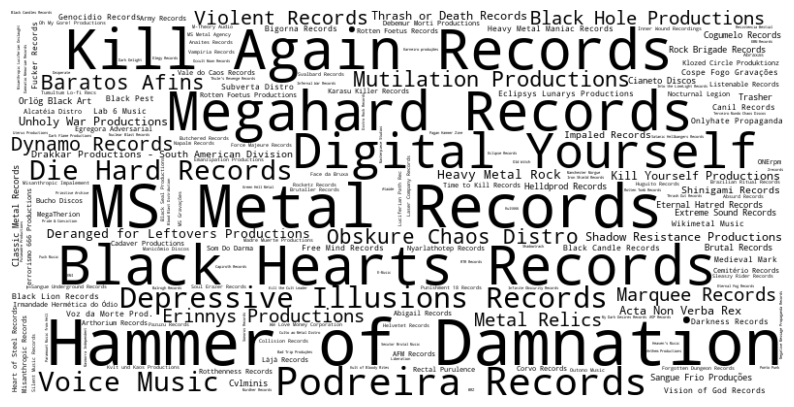

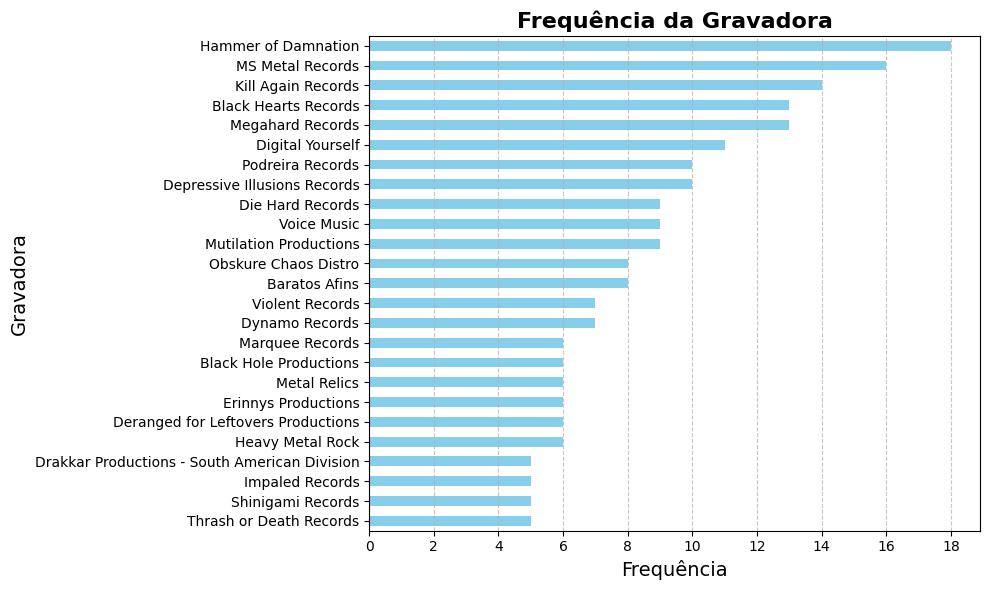

In [204]:
# 1. Extrair lista de gravadoras, separando por '|'
lista_gravadoras = df['gravadora_mais_recente'].str.split('|')

# 2. Explodir a lista para ter uma gravadora por linha
lista_gravadoras_explodida = lista_gravadoras.explode()

# 3. Filtrar para remover gravadoras 'Unsigned/independent'
lista_gravadoras_filtrada = lista_gravadoras_explodida.loc[lista_gravadoras_explodida != 'Unsigned/independent']

# 4. Contar frequência de cada gravadora
frequencia_gravadoras = lista_gravadoras_filtrada.value_counts()

# 5. Criar word cloud a partir da frequência
# Defina a função cor_preta conforme sua necessidade, exemplo simples:
def cor_preta(word, font_size, position, orientation, random_state=None, **kwargs):
    return "black"

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencia_gravadoras)
wordcloud = wordcloud.recolor(color_func=cor_preta)

# 6. Mostrar word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 7. Plotar gráfico de barras horizontais com as 20 gravadoras mais frequentes
plt.figure(figsize=(10, 6))
ax = frequencia_gravadoras.sort_values(ascending=False).head(25).plot(kind='barh', color='skyblue')
ax.invert_yaxis()  # Para ordem do maior para o menor

plt.title('Frequência da Gravadora', fontsize=16, fontweight='bold')
plt.xlabel('Frequência', fontsize=14)
plt.ylabel('Gravadora', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 8. Garantir que o eixo x mostre apenas números inteiros
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# 9. Salvar ranking das gravadoras em CSV
frequencia_gravadoras.to_csv('ranking_gravadoras.csv')

### Qual é a proporção de bandas sem gravadora?

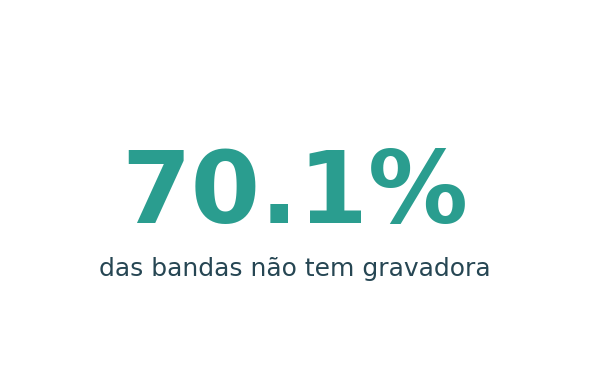

In [206]:
total_bandas = len(df)
sem_gravadora = (df['gravadora_mais_recente'] == 'Unsigned/independent').sum()
proporcao = sem_gravadora / total_bandas
plot_big_number(proporcao, "das bandas não tem gravadora")

### Das bandas que tiveram hiatos, qual é distribuição da quantidade de hiatos banda?

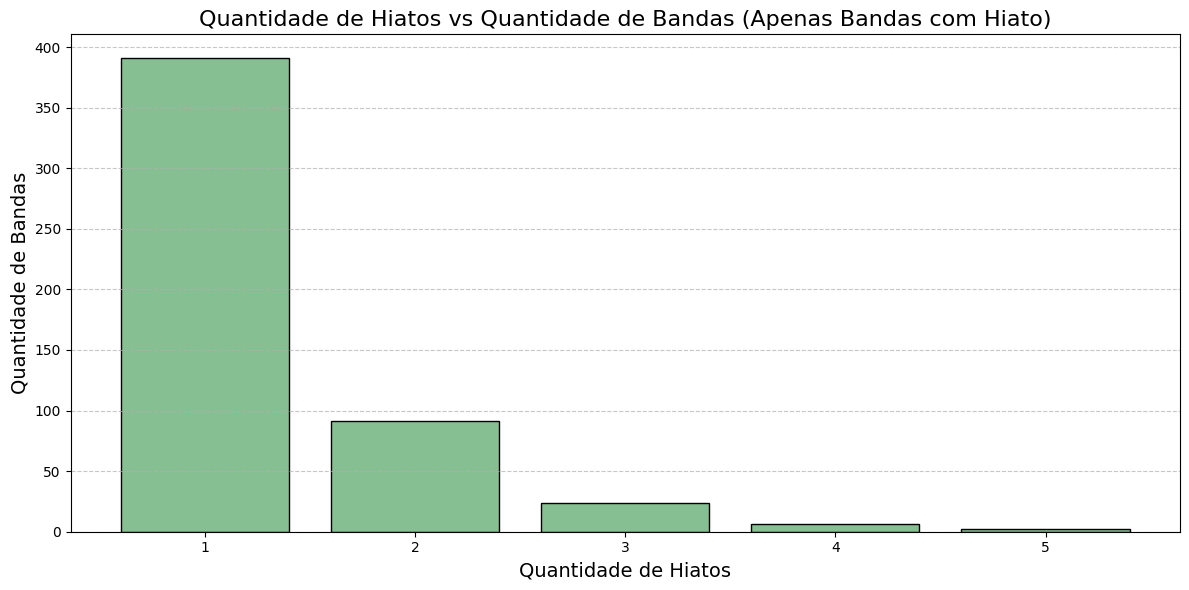

In [210]:
# Função para contar hiatos a partir da string 'anos_atividade'
def contar_hiatos(anos_atividade):
    if pd.isna(anos_atividade):
        return 0
    periodos = anos_atividade.split(',')
    return max(len(periodos) - 1, 0)

# Criar coluna 'quantidade_hiatos'
df['quantidade_hiatos'] = df['anos_atividade'].apply(contar_hiatos)

# Filtrar apenas bandas que tiveram hiato (quantidade_hiatos > 0)
df_com_hiato = df[df['quantidade_hiatos'] > 0]

# Contar quantas bandas têm cada quantidade de hiatos
contagem_hiatos = df_com_hiato['quantidade_hiatos'].value_counts().sort_index()

# Preparar dados para o gráfico
quantidades = contagem_hiatos.index
frequencias = contagem_hiatos.values

# Plotar gráfico
plt.figure(figsize=(12,6))
plt.bar(quantidades, frequencias, color='#86bf91', edgecolor='black')

max_idx = np.argmax(frequencias)
max_hiato = quantidades[max_idx]

plt.title('Quantidade de Hiatos vs Quantidade de Bandas (Apenas Bandas com Hiato)', fontsize=16)
plt.xlabel('Quantidade de Hiatos', fontsize=14)
plt.ylabel('Quantidade de Bandas', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Prêmios:

Banda mais antiga
Banda mais antiga ainda ativa
Banda com mais hiatos

In [211]:
# Banda mais antiga (menor ano_formacao)
min_year = df['ano_formacao'].min()
bandas_mais_antigas = df[df['ano_formacao'] == min_year]['nome'].tolist()

# Banda mais antiga ainda ativa (considera 'present' em anos_atividade)
# Filtra bandas que possuem 'present' em anos_atividade
df_ativas = df[df['anos_atividade'].str.contains('present', case=False, na=False)]
min_year_ativa = df_ativas['ano_formacao'].min()
bandas_mais_antigas_ativas = df_ativas[df_ativas['ano_formacao'] == min_year_ativa]['nome'].tolist()

# Banda com mais hiatos
# Para contar hiatos, conta quantos períodos separados existem na coluna anos_atividade (separados por vírgula)
def contar_periodos(anos_atividade):
    # Divide por vírgula e conta quantos períodos existem
    return len([p.strip() for p in anos_atividade.split(',')])

df['num_periodos'] = df['anos_atividade'].apply(contar_periodos)
max_hiatos = df['num_periodos'].max()
bandas_mais_hiatos = df[df['num_periodos'] == max_hiatos]['nome'].tolist()

# Resultados
print("Banda(s) mais antiga(s):", bandas_mais_antigas)
print("Banda(s) mais antiga(s) ainda ativa(s):", bandas_mais_antigas_ativas)
print("Banda(s) com mais hiatos:", bandas_mais_hiatos)

Banda(s) mais antiga(s): ['Patrulha do Espaço']
Banda(s) mais antiga(s) ainda ativa(s): ['Patrulha do Espaço']
Banda(s) com mais hiatos: ['Azbuk', 'Deathcharge']
